In [1]:
import datetime as dt
import sys
import json
import os
from typing import Any, List, Dict

from ibm_quantum_connector import QuantumServiceManager

In [2]:
def _collect_top_level_readout_error(props):
    ro = getattr(props, "readout_error", None)
    if isinstance(ro, list):
        return ro
    return None


def _props_to_serializable_dict(props, backend_name: str, snapshot_iso: str) -> Dict[str, Any]:
    # Metadata
    out: Dict[str, Any] = {
        "backend_name": getattr(props, "backend_name", backend_name),
        "backend_version": getattr(props, "backend_version", None),
        "last_update_date": str(getattr(props, "last_update_date", None)),
        "snapshot_utc": snapshot_iso,
    }

    # Qubits (serialize as name-keyed map)
    qubits = getattr(props, "qubits", None) or []
    top_level_ro = _collect_top_level_readout_error(props)
    qubits_map: Dict[str, Dict[str, Any]] = {}
    for qi, qitems in enumerate(qubits):
        qname = f"q{qi}"
        entry: Dict[str, Any] = {}
        try:
            for item in qitems or []:
                name = getattr(item, "name", None)
                value = getattr(item, "value", None)
                unit = getattr(item, "unit", None)
                if name is None:
                    continue
                entry[name] = {"value": value, "unit": unit}
        except Exception:
            pass
        if top_level_ro is not None and qi < len(top_level_ro) and "readout_error" not in entry:
            entry["readout_error"] = {"value": top_level_ro[qi], "unit": None}
        qubits_map[qname] = entry
    out["qubits"] = qubits_map

    # Gates (serialize as name-keyed map; value is a list of entries per qubit-set)
    gates = getattr(props, "gates", None) or []
    gates_map: Dict[str, List[Dict[str, Any]]] = {}
    for gate in gates:
        gname = getattr(gate, "gate", None)
        glabel = getattr(gate, "name", None) or gname
        gqubits = list(getattr(gate, "qubits", None) or [])
        params = {}
        for p in getattr(gate, "parameters", None) or []:
            pname = getattr(p, "name", None)
            pval = getattr(p, "value", None)
            punit = getattr(p, "unit", None)
            if pname is not None:
                params[pname] = {"value": pval, "unit": punit}
        gates_map.setdefault(glabel, []).append({"qubits": gqubits, "parameters": params})
    out["gates"] = gates_map

    return out


def _iso_filename(dt_obj: dt.datetime) -> str:
    # ISO-like but filesystem friendly
    return dt_obj.strftime("%Y-%m-%dT%H-%M-%SZ")


def _save_snapshot_json(backend, when: dt.datetime, out_dir: str) -> str | None:
    # Fetch properties
    try:
        props = backend.properties(datetime=when)
    except Exception as e:
        print(f"Failed to fetch properties for {when}: {e}")
        return None

    # Build serializable object
    snapshot_iso = when.astimezone(dt.timezone.utc).isoformat()
    data = _props_to_serializable_dict(props, backend.name, snapshot_iso)

    # Ensure directory
    os.makedirs(out_dir, exist_ok=True)

    # Write file
    fname = f"{backend.name}_{_iso_filename(when.astimezone(dt.timezone.utc))}.json"
    fpath = os.path.join(out_dir, fname)
    with open(fpath, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    return fpath





In [3]:
def _midnights_last_30(now_utc: dt.datetime) -> List[dt.datetime]:
    start_day = now_utc.date()
    marks: List[dt.datetime] = []
    for i in range(30):
        day = start_day - dt.timedelta(days=i)
        marks.append(dt.datetime(day.year, day.month, day.day, tzinfo=dt.timezone.utc))
    return sorted(marks)

In [4]:
out_dir = "backend_properties"

mgr = QuantumServiceManager()
if not mgr.connect():
    print("Could not connect to IBM Quantum. Check config/quantum_config.json")
    sys.exit(2)

backend = mgr.select_backend()
if backend is None:
    print("Failed to select backend from config.")
    sys.exit(1)

now_utc = dt.datetime.now(dt.timezone.utc)
marks = _midnights_last_30(now_utc)
for when in marks:
    path = _save_snapshot_json(backend, when, out_dir)
    if path:
        print(f"Saved: {path}")

Saved: backend_properties/ibm_brisbane_2025-09-23T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-09-24T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-09-25T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-09-26T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-09-27T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-09-28T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-09-29T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-09-30T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-10-01T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-10-02T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-10-03T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-10-04T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-10-05T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-10-06T00-00-00Z.json
Saved: backend_properties/ibm_brisbane_2025-10-07T00-00-00Z.json
Saved: backend_properties

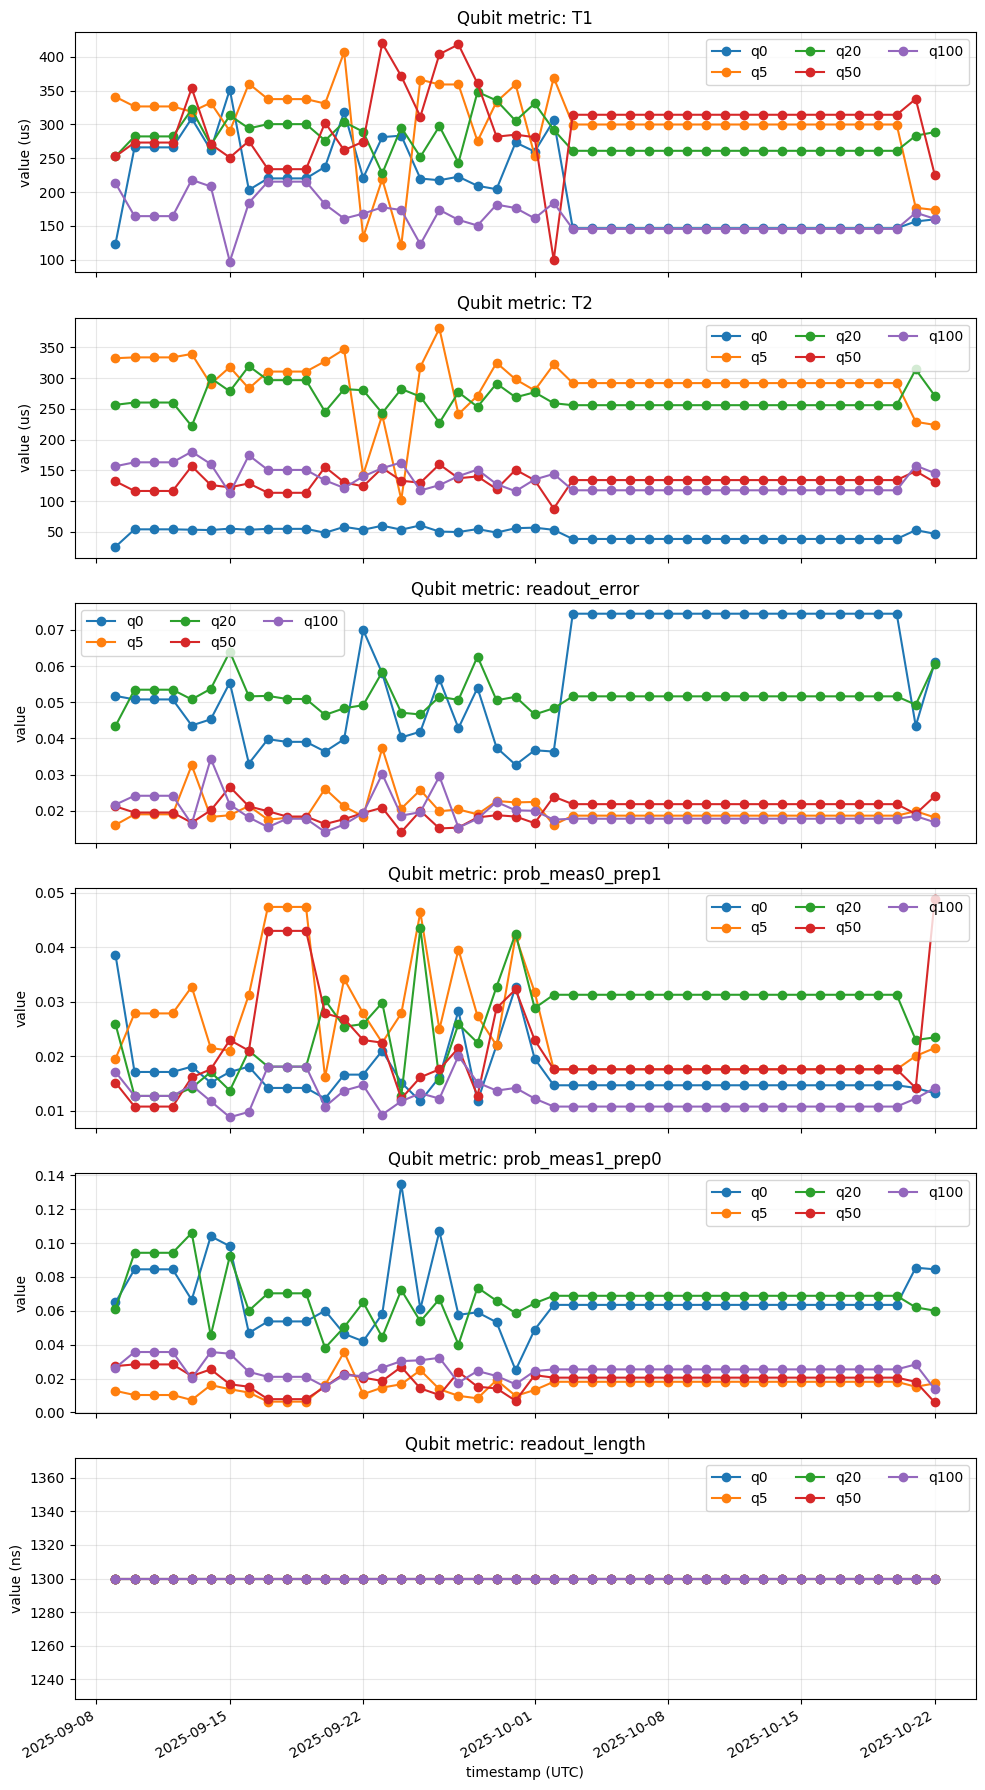

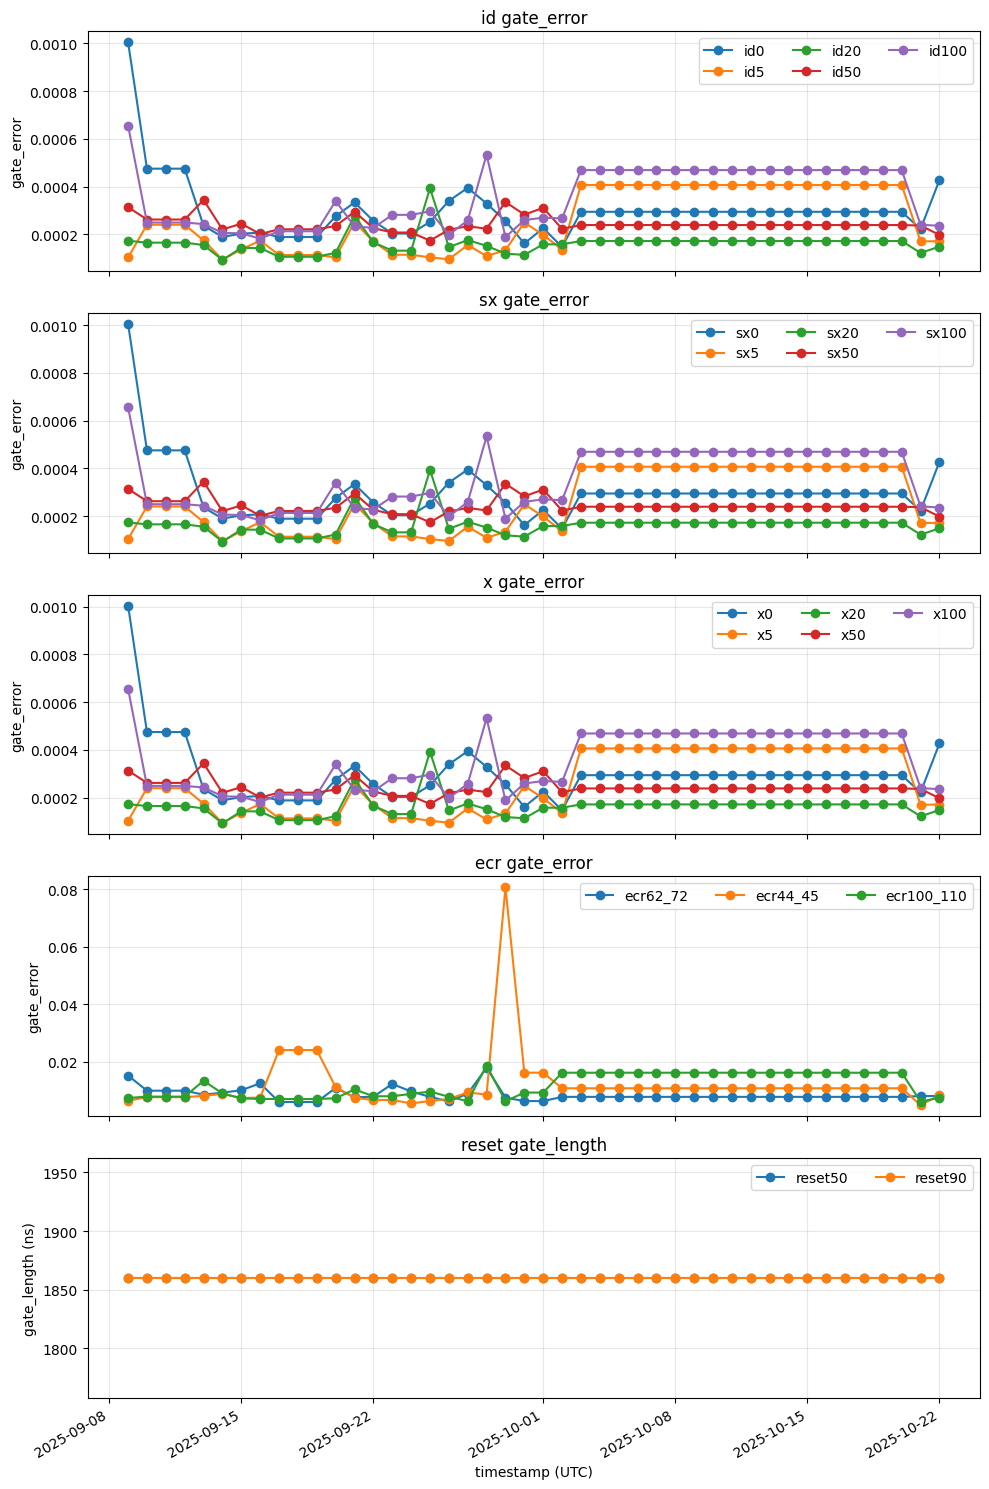

In [5]:
# Visualization: Specific qubits and gates
import glob
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt

# Helpers to normalize data across old(list) and new(map) formats

def _normalize_qubits(qobj):
    if isinstance(qobj, dict):
        return qobj  # name -> metrics
    if isinstance(qobj, list):
        result = {}
        for i, q in enumerate(qobj):
            name = None
            if isinstance(q, dict):
                name = q.get("name")
            if not isinstance(name, str) or not name:
                name = f"q{i}"
            result[name] = q if isinstance(q, dict) else {}
        return result
    return {}

def _normalize_gates(gobj):
    # Return mapping: (name, tuple(qubits)) -> parameters dict
    mapping = {}
    if isinstance(gobj, dict):
        for gname, entries in gobj.items():
            if not isinstance(entries, list):
                continue
            for ent in entries:
                if not isinstance(ent, dict):
                    continue
                qubits = tuple(ent.get("qubits", []))
                params = ent.get("parameters", {})
                mapping[(gname, qubits)] = params
        return mapping
    if isinstance(gobj, list):
        for g in gobj:
            if not isinstance(g, dict):
                continue
            gname = g.get("name") or g.get("gate")
            qubits = tuple(g.get("qubits", []))
            params = g.get("parameters", {})
            mapping[(gname, qubits)] = params
        return mapping
    return {}

# Load snapshots
snap_dir = Path("backend_properties")
files = sorted(glob.glob(str(snap_dir / "*.json")))
if not files:
    print("No snapshot files found under backend_properties/")
else:
    snapshots = []
    for fp in files:
        try:
            with open(fp, "r", encoding="utf-8") as f:
                data = json.load(f)
            ts = data.get("snapshot_utc")
            t = None
            if ts:
                try:
                    t = datetime.fromisoformat(ts)
                except Exception:
                    t = None
            snapshots.append((t, data))
        except Exception as e:
            print(f"Failed to load {fp}: {e}")
    snapshots = [(t, d) for t, d in snapshots if t is not None]
    snapshots.sort(key=lambda x: x[0])

    if not snapshots:
        print("No valid snapshots with timestamps found.")
    else:
        time_points = [t for t, _ in snapshots]

        # 1) Qubit metrics figure (6 subplots)
        qubit_names = ["q0", "q5", "q20", "q50", "q100"]
        qubit_metrics = [
            "T1",
            "T2",
            "readout_error",
            "prob_meas0_prep1",
            "prob_meas1_prep0",
            "readout_length",
        ]
        # Collect data + units
        qubit_values = {mk: {qn: [] for qn in qubit_names} for mk in qubit_metrics}
        qubit_units = {mk: None for mk in qubit_metrics}
        for _, d in snapshots:
            qmap = _normalize_qubits(d.get("qubits", {}))
            for qn in qubit_names:
                q = qmap.get(qn, {})
                for mk in qubit_metrics:
                    v = q.get(mk)
                    if isinstance(v, dict):
                        if qubit_units[mk] is None and v.get("unit") not in (None, ""):
                            qubit_units[mk] = v.get("unit")
                        qubit_values[mk][qn].append(v.get("value"))
                    else:
                        qubit_values[mk][qn].append(None)

        # Plot 6-subplot figure
        fig1, axes1 = plt.subplots(6, 1, figsize=(10, 18), sharex=True)
        for ax, mk in zip(axes1, qubit_metrics):
            for qn in qubit_names:
                ax.plot(time_points, qubit_values[mk][qn], marker="o", label=qn)
            unit = f" ({qubit_units[mk]})" if qubit_units.get(mk) else ""
            ax.set_title(f"Qubit metric: {mk}")
            ax.set_ylabel(f"value{unit}")
            ax.grid(True, alpha=0.3)
            ax.legend(ncol=3)
        axes1[-1].set_xlabel("timestamp (UTC)")
        fig1.autofmt_xdate(rotation=30)
        plt.tight_layout()
        plt.show()

        # 2) Gate metrics figure (5 subplots)
        # Define targets
        id_targets = [("id", (i,)) for i in [0, 5, 20, 50, 100]]
        sx_targets = [("sx", (i,)) for i in [0, 5, 20, 50, 100]]
        x_targets  = [("x",  (i,)) for i in [0, 5, 20, 50, 100]]
        ecr_targets = [("ecr", (62, 72)), ("ecr", (44, 45)), ("ecr", (100, 110))]
        reset_targets = [("reset", (50,)), ("reset", (90,))]

        # Helper to get series for a single gate key and param
        def _gate_series_over_time(name, qubits_tuple, param_key):
            vals = []
            units = []
            for _, d in snapshots:
                gmap = _normalize_gates(d.get("gates", {}))
                params = None
                # Build candidate gate names to match e.g. 'id', 'id121', 'ecr62_72'
                candidates = [name]
                if len(qubits_tuple) == 1:
                    qstr = str(qubits_tuple[0])
                    candidates.append(f"{name}{qstr}")
                if len(qubits_tuple) >= 2:
                    join_fwd = "_".join(str(q) for q in qubits_tuple)
                    join_rev = "_".join(str(q) for q in reversed(qubits_tuple))
                    candidates.append(f"{name}{join_fwd}")
                    candidates.append(f"{name}{join_rev}")
                # Try matches against candidates and qubit orders
                for cname in candidates:
                    if (cname, qubits_tuple) in gmap:
                        params = gmap[(cname, qubits_tuple)]
                        break
                    if len(qubits_tuple) == 2 and (cname, (qubits_tuple[1], qubits_tuple[0])) in gmap:
                        params = gmap[(cname, (qubits_tuple[1], qubits_tuple[0]))]
                        break
                if params is None:
                    # fallback to base name
                    if (name, qubits_tuple) in gmap:
                        params = gmap[(name, qubits_tuple)]
                    elif len(qubits_tuple) == 2 and (name, (qubits_tuple[1], qubits_tuple[0])) in gmap:
                        params = gmap[(name, (qubits_tuple[1], qubits_tuple[0]))]
                if isinstance(params, dict):
                    v = params.get(param_key)
                    if isinstance(v, dict):
                        vals.append(v.get("value"))
                        units.append(v.get("unit"))
                    else:
                        vals.append(None)
                        units.append(None)
                else:
                    vals.append(None)
                    units.append(None)
            # pick first non-empty unit
            unit = next((u for u in units if u not in (None, "")), None)
            return vals, unit

        # Build series groups
        groups = [
            ("id gate_error", id_targets, "gate_error"),
            ("sx gate_error", sx_targets, "gate_error"),
            ("x gate_error",  x_targets,  "gate_error"),
            ("ecr gate_error", ecr_targets, "gate_error"),
            ("reset gate_length", reset_targets, "gate_length"),
        ]

        fig2, axes2 = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
        for ax, (title, targets, param_key) in zip(axes2, groups):
            subplot_unit = None
            for name, qts in targets:
                series, unit = _gate_series_over_time(name, tuple(qts), param_key)
                if subplot_unit is None and unit not in (None, ""):
                    subplot_unit = unit
                label = f"{name}{'_'.join(map(str, qts)) if len(qts) > 1 else qts[0]}"
                ax.plot(time_points, series, marker="o", label=label)
            ax.set_title(title)
            ax.set_ylabel(param_key + (f" ({subplot_unit})" if subplot_unit else ""))
            ax.grid(True, alpha=0.3)
            ax.legend(ncol=3)
        axes2[-1].set_xlabel("timestamp (UTC)")
        fig2.autofmt_xdate(rotation=30)
        plt.tight_layout()
        plt.show()
